### Deepfake more than images 
Deepfake is often used for videos, which is why we will take our analysis a step further. We will start with a short video of Trevor Noah, and then the same video, deepfaked with Barack Obamas Face. First we have to get frames from the videos. Then we will built a simple classifier. 
The data used was provided an Kaggle by VINIT DANTKALE (2020), https://www.kaggle.com/datasets/vinitdantkale/deepfake

I learned how to abstract frames from a video here: https://thepythoncode.com/article/extract-frames-from-videos-in-python?utm_content=cmp-true  by Abdou Rockikz. We gonna use the MoviePy Library from Open CV 

In [14]:
!pip install moviepy numpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 6.3 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110721 sha256=48dfe4f5143e58af42f7cad62691b273eec2c27fda20031ed45dc74a0e2f8859
  Stored in directory: /Users/jillcakmak/Library/Caches/pip/wheels/29/15/e4/4f790bec6acd51a00b67e8ee1394f0bc6e0135c315f8ff399a
  Created wheel for imageio_ffmpeg: filename=imageio_ffmpeg-0.4.9-py3-none-any.whl size=16367 sha256=ee4088d4ba8ecd3d631fdaa20058de11ccc71f9c2f2ceb363e2d64ce3246ca89
  Stored in directory: /Users/jillcakmak/Library/Caches/pip/wheels/a0/a2/a5/801b8c9041c8149b486509ade5eb48e3c474d17d31f3746860
Successfully built moviepy imageio_ffmpeg
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1


In [15]:
#First Imports 
from moviepy.editor import VideoFileClip
import numpy as np
import os
from datetime import timedelta

In [16]:
# i.e if video of duration 30 seconds, saves 10 frame per second = 300 frames saved in total
SAVING_FRAMES_PER_SECOND = 10

In [17]:
#Supportive Function 
def format_timedelta(td):
    """Utility function to format timedelta objects in a cool way (e.g 00:00:20.05) 
    omitting microseconds and retaining milliseconds"""
    result = str(td)
    try:
        result, ms = result.split(".")
    except ValueError:
        return (result + ".00").replace(":", "-")
    ms = int(ms)
    ms = round(ms / 1e4)
    return f"{result}.{ms:02}".replace(":", "-")

In [18]:
#Main Function 
def main(video_file):
    # load the video clip
    video_clip = VideoFileClip(video_file)
    # make a folder by the name of the video file
    filename, _ = os.path.splitext(video_file)
    filename += "-moviepy"
    if not os.path.isdir(filename):
        os.mkdir(filename)

    # if the SAVING_FRAMES_PER_SECOND is above video FPS, then set it to FPS (as maximum)
    saving_frames_per_second = min(video_clip.fps, SAVING_FRAMES_PER_SECOND)
    # if SAVING_FRAMES_PER_SECOND is set to 0, step is 1/fps, else 1/SAVING_FRAMES_PER_SECOND
    step = 1 / video_clip.fps if saving_frames_per_second == 0 else 1 / saving_frames_per_second
    # iterate over each possible frame
    for current_duration in np.arange(0, video_clip.duration, step):
        # format the file name and save it
        frame_duration_formatted = format_timedelta(timedelta(seconds=current_duration))
        frame_filename = os.path.join(filename, f"frame{frame_duration_formatted}.jpg")
        # save the frame with the current duration
        video_clip.save_frame(frame_filename, current_duration) 

In [19]:
if __name__ == "__main__":
    import sys
    video_file = "/Users/jillcakmak/Documents/GitHub/AI_Project/data/fakevideo.mp4"
    main(video_file)

Let's do the same with our Real Video 

In [21]:
if __name__ == "__main__":
    import sys
    video_file = "/Users/jillcakmak/Documents/GitHub/AI_Project/data/realvideo.mp4"
    main(video_file)

Now that we have 2 directories with fake and real images of the video we can built a simple Classifier as we learned in class. After that we can check if image detection might improve the classifier 

In [22]:
#Imports first 
import os
import torch
import torchvision
import cv2
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.utils as vutils
import torchvision.transforms as transforms
import argparse

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from imutils import paths
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.utils import resample
from sklearn.metrics import classification_report

In [37]:
#I moved the frames of the video snippets into a new folder 'Video_data'
device = 'mps'
momentum = 0.9
num_epochs = 40
num_classes = 2 #fake & real 
val_size = 0.3
batch_size = 100
learn_rate = 0.001
freeze_lower_layers = True
data_path = "/Users/jillcakmak/Documents/GitHub/AI_Project/data/Video_data"

In [38]:
#next we define training and validation 
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomAffine(degrees=(-30,30),translate=(0.15,0.15),scale=(0.85,1.15)),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
        transforms.RandomResizedCrop(size=(224, 224), antialias=True),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [39]:
val_transform = transforms.Compose(
    [   
        torchvision.transforms.Resize(224, antialias=True),
        torchvision.transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [40]:
#Lets split our data by train, test and validation 
dataset = ImageFolder(data_path, transform=train_transform)
num_classes = 2 #len(dataset.classes)

# Get length of dataset and indicies
num_train = len(dataset)
indices = list(range(num_train))

# Get train / val split for data points
train_indices, test_indices = train_test_split(indices, test_size=val_size, random_state=42)
train_indices, val_indices = train_test_split(train_indices, test_size=val_size, random_state=42)

# Override dataset classes to only be samples for each split
train_subset = torch.utils.data.Subset(dataset, train_indices)
test_subset = torch.utils.data.Subset(dataset, test_indices)
val_subset = torch.utils.data.Subset(dataset, val_indices)

# Create data loaders
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

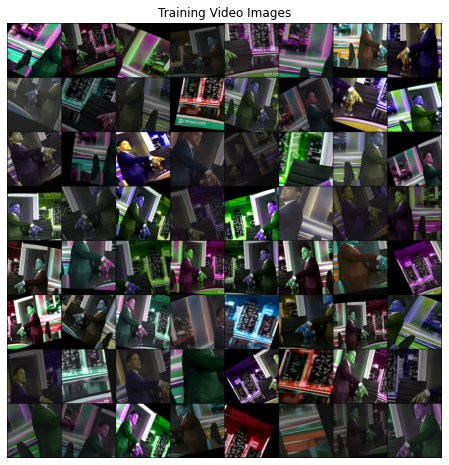

In [41]:
#Now we visualise our training dataset, which should only be images of the Trevor Noah /Barack Obama Deepfake 
# Plot some training images
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Video Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

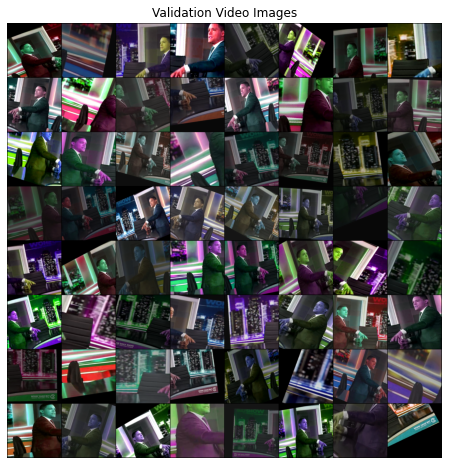

In [42]:
# Plot some validation images
real_batch = next(iter(val_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Validation Video Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [43]:
#Now we will use the pretrained model from week 3 
model = torchvision.models.resnet18(weights='IMAGENET1K_V1')

# Freeze weights
if freeze_lower_layers == True:
    for param in model.parameters():
        param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model.to(device)

#this code was originally sources from: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html as described in class

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [44]:
# Cross entropy loss for training classification
criterion = nn.CrossEntropyLoss()

# Stochastic gradient descent loss
optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=momentum)

In [45]:
#Now we will train and calculate Validation loss. As we learned ideally we should stop the model when the validation loss goes up and training goes down 
train_losses = []
val_losses = []

best_loss = 100000
for epoch in range(num_epochs): 
    train_loss = 0.0
    
    # Training loop
    for i, data in enumerate(train_loader, 0):
        # Get data
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Process data
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Update model weights
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
    
    # Validation loop
    with torch.no_grad():
        val_loss = 0.0
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    # Normalise cumulative losses to dataset size
    train_loss = train_loss / len(train_loader)
    val_loss = val_loss / len(val_loader)
    
    # Added cumulative losses to lists for later display
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch + 1}, train loss: {train_loss:.3f}, val loss: {val_loss:.3f}')
    
    # if validation score is lowest so far, save the model, ideal model 
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_finetuned_video_model.pt')

Epoch 1, train loss: 0.729, val loss: 0.753
Epoch 2, train loss: 0.740, val loss: 0.715
Epoch 3, train loss: 0.728, val loss: 0.693
Epoch 4, train loss: 0.716, val loss: 0.722
Epoch 5, train loss: 0.724, val loss: 0.744
Epoch 6, train loss: 0.697, val loss: 0.708
Epoch 7, train loss: 0.698, val loss: 0.704
Epoch 8, train loss: 0.701, val loss: 0.674
Epoch 9, train loss: 0.682, val loss: 0.685
Epoch 10, train loss: 0.688, val loss: 0.683
Epoch 11, train loss: 0.684, val loss: 0.674
Epoch 12, train loss: 0.692, val loss: 0.670
Epoch 13, train loss: 0.700, val loss: 0.684
Epoch 14, train loss: 0.690, val loss: 0.698
Epoch 15, train loss: 0.676, val loss: 0.685
Epoch 16, train loss: 0.676, val loss: 0.690
Epoch 17, train loss: 0.687, val loss: 0.692
Epoch 18, train loss: 0.669, val loss: 0.657
Epoch 19, train loss: 0.676, val loss: 0.687
Epoch 20, train loss: 0.670, val loss: 0.691
Epoch 21, train loss: 0.697, val loss: 0.689
Epoch 22, train loss: 0.667, val loss: 0.643
Epoch 23, train los

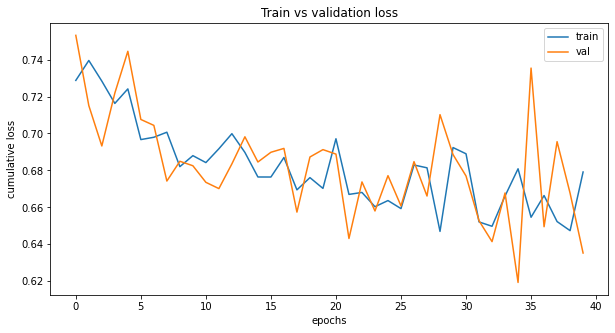

In [46]:
#Now we will plot the outcome (Training and Validation)
#Plotting Training and Validation loss 
plt.figure(figsize=(10,5))
plt.title("Train vs validation loss")
plt.plot(train_losses,label="train")
plt.plot(val_losses,label="val")
plt.xlabel("epochs")
plt.ylabel("cumulative loss")
plt.legend()
plt.show()

In [47]:
    # Training loop from above but altered to test 
total= 0
correct = 0

for i, data in enumerate(test_loader, 0):
        # Get data
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Process data
        outputs = model(inputs)

        # Compute predictions #this part is from chat-gpt 
        _, predicted = torch.max(outputs.data, 1)

         # Calculate accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

In [48]:
# Print the accuracy
print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 58 %


#### Accuracy 20 & 40 Epochs 
Our Accuracy is **60% with 20 Epochs**, and **58 with 40 Epochs** meaning that yet again the Model is overfitted with more Epochs.<br> The more is not necceccarly the better. However, due to the limited data, and in that case visual differences in frames I would have expected a much better outcome. <br>Nevertheless, it might be just too limited in data to be trained efficently. To check this hypothesis we will upgrade the video database with some Videos from the Web. <br>The videos used will be from politcians only as I can obtain a vast amount of data of that category as well as some valuable real footage exists which is comparative. The next steps about how I edited the videos etc. will be explained in the notebook **AI_Project_part2_moredata**